In [1]:
# if our large test file is available, use it. Otherwise, use file generated from toy_mstis_2_run.ipynb
import os
test_file = "../toy_mstis_1k_OPS1.nc"
filename = test_file if os.path.isfile(test_file) else "mstis.nc"
print 'Using file `%s` for analysis' % filename

Using file `../toy_mstis_1k_OPS1.nc` for analysis


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import openpathsampling as paths
import pandas as pd

In [3]:
%%time
storage = paths.AnalysisStorage(filename)

CPU times: user 4.59 s, sys: 385 ms, total: 4.98 s
Wall time: 5.04 s


In [4]:
network = storage.networks[0]
scheme = storage.schemes[0]

In [5]:
stateA = storage.volumes['A']
stateB = storage.volumes['B']
stateC = storage.volumes['C']
all_states = [stateA, stateB, stateC]  # all_states gives the ordering

# Simplified Analysis

In [6]:
from openpathsampling.analysis.tis_analysis import StandardTISAnalysis

In [7]:
# the scheme is only required if using the minus move for the flux
tis_analysis = StandardTISAnalysis(
    network=network,
    scheme=scheme,
    max_lambda_calcs={t: {'bin_width': 0.05, 'bin_range': (0.0, 0.5)}
                      for t in network.sampling_transitions}
)

In [8]:
%%time
tis_analysis.rate_matrix(steps=storage.steps).to_pandas(order=all_states)

/Users/dwhs/Dropbox/msm-tis/openpathsampling/numerics/wham.py:336: RuntimeWarning: invalid value encountered in divide
  addends_k = np.divide(numerator_byQ, sum_over_Z_byQ)
/Users/dwhs/Dropbox/msm-tis/openpathsampling/numerics/wham.py:409: RuntimeWarning: invalid value encountered in double_scalars
  output[val] = sum_k_Hk_Q[val] / sum_w_over_Z


CPU times: user 10.6 s, sys: 126 ms, total: 10.7 s
Wall time: 10.9 s


,A,B,C
A,NaN,3.20995e-05,0.000101309
B,0.00103954,NaN,0.000586511
C,2.12203e-05,0,NaN


## Looking at the parts of the calculation

Once you run the rate calculation (or if you run `tis_analysis.calculate(steps)`, you have already cached a large number of subcalculations. All of those are available in the `results` dictionary, although the analysis object has a number of conveniences to access some of them.

Looking at the keys of the results dictionary, we can see what has been cached:

In [9]:
tis_analysis.results.keys()

['max_lambda',
 'conditional_transition_probability',
 'flux',
 'rate',
 'total_crossing_probability',
 'transition_probability']

In practice, however, we won't go directly to the results dictionary. We'd rather use the convenience methods that make it easier to get to the interesting results.

We'll start by looking at the flux:

In [10]:
tis_analysis.flux_matrix

{(<openpathsampling.volume.CVDefinedVolume at 0x10f82dc10>,
  <openpathsampling.volume.CVDefinedVolume at 0x10f82d590>): 0.015579020252726327,
 (<openpathsampling.volume.CVDefinedVolume at 0x110d42810>,
  <openpathsampling.volume.CVDefinedVolume at 0x118eedb50>): 0.020049008687903762,
 (<openpathsampling.volume.CVDefinedVolume at 0x110d42910>,
  <openpathsampling.volume.CVDefinedVolume at 0x118eedc50>): 0.027932960893854747}

Next we look at the total crossing probability (i.e., the crossing probability, joined by WHAM) for each sampled transition. We could also look at this per physical transition, but of course $A\to B$ and $A\to C$ are identical in MSTIS -- only the initial state matters.

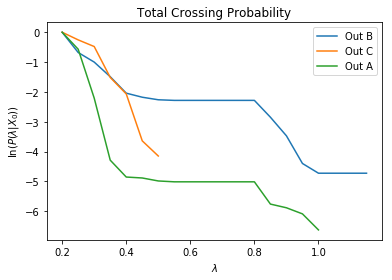

In [11]:
for transition in network.sampling_transitions:
    label = transition.name
    tcp = tis_analysis.total_crossing_probability[transition]
    plt.plot(tcp.x, np.log(tcp), label=label)
plt.title("Total Crossing Probability")
plt.xlabel("$\lambda$")
plt.ylabel("$\ln(P(\lambda | X_0))$")
plt.legend();

We may want to look in more detail at one of these, by checking the per-ensemble crossing probability (as well at the total crossing probability). Here we select based on the $A\to B$ transition, we would get the same results if we selected the transition using either `trans = network.from_state[stateA]` or `trans = network.transitions[(stateA, stateC)]`.

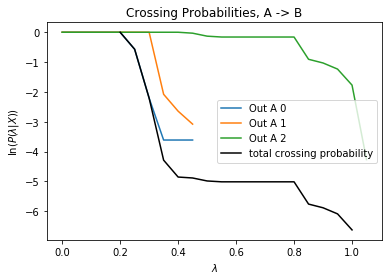

In [12]:
state_pair = (stateA, stateB)
trans = network.transitions[state_pair]
for ens in trans.ensembles:
    crossing = tis_analysis.crossing_probability(ens)
    label = ens.name
    plt.plot(crossing.x, np.log(crossing), label=label)
tcp = tis_analysis.total_crossing_probability[state_pair]
plt.plot(tcp.x, np.log(tcp), '-k', label="total crossing probability")
plt.title("Crossing Probabilities, " + stateA.name + " -> " + stateB.name)
plt.xlabel("$\lambda$")
plt.ylabel("$\ln(P(\lambda | X))$")
plt.legend();

Finally, we look at the last part of the rate calculation: the conditional transition probability. This is calculated for the outermost interface in each interface set.

In [13]:
tis_analysis.conditional_transition_probability

,B,C,A
Out B 2,0.196,0.290,0.514
Out A 2,0.205,0.647,0.148
Out C 2,NaN,0.994,0.006


## Flux from the minus move

In [14]:
from openpathsampling.analysis.tis_analysis import MinusMoveFlux

In [15]:
flux_calc = MinusMoveFlux(scheme)

In [16]:
flux_calc.calculate(storage.steps)

{(<openpathsampling.volume.CVDefinedVolume at 0x10f82dc10>,
  <openpathsampling.volume.CVDefinedVolume at 0x10f82d590>): 0.015579020252726327,
 (<openpathsampling.volume.CVDefinedVolume at 0x110d42810>,
  <openpathsampling.volume.CVDefinedVolume at 0x118eedb50>): 0.020049008687903762,
 (<openpathsampling.volume.CVDefinedVolume at 0x110d42910>,
  <openpathsampling.volume.CVDefinedVolume at 0x118eedc50>): 0.027932960893854747}

In [17]:
%%time
network.hist_args['max_lambda'] = {'bin_width': 0.05, 'bin_range': (0.0, 0.5)}
network.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }
network.rate_matrix(storage.steps, force=True)

CPU times: user 1.29 s, sys: 6 ms, total: 1.29 s
Wall time: 1.29 s


In [18]:
network.rate_matrix(storage.steps)

,A,B,C
A,NaN,3.34326e-05,0.000105517
B,0.00105543,NaN,0.000595478
C,2.11191e-05,0,NaN


In [19]:
trans = network.sampling_transitions[2]
print trans.stateA, repr(trans.stateA)

{x|opA(x) in [0.0, 0.2]} <openpathsampling.volume.CVDefinedVolume object at 0x110d42810>


In [20]:
trans.minus_count_sides

{'in': [892, 105, 57, 101, 298, 170, 230, 71, 68],
 'out': [11, 24, 6, 40, 8, 14, 9, 30, 21]}

In [21]:
print len(trans.minus_count_sides['in']), len(trans.minus_count_sides['out'])

9 9


In [22]:
%%time
flux_dicts = flux_calc.intermediates(storage.steps)[0]

CPU times: user 9.21 s, sys: 135 ms, total: 9.35 s
Wall time: 9.49 s
